<a href="https://colab.research.google.com/github/Spin-Chemistry-Labs/radicalpy/blob/187-google-colab-tutorials/examples/tutorials/05_introduction_to_magnetic_field_effects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Tutorial 5 - Introduction to magnetic field effects


&copy; Lewis M. Antill, 2025

This tutorial aims to...

In [ ]:
!pip install radicalpy

In [38]:
import matplotlib.pyplot as plt
import numpy as np

import radicalpy as rp
from radicalpy.classical import Rate, RateEquations
from radicalpy.data import Triplet
from radicalpy.experiments import anisotropy, mary, kine_quantum_mary, steady_state_mary
from radicalpy.kinetics import Haberkorn, HaberkornFree
from radicalpy.plot import plot_general
from radicalpy import relaxation
from radicalpy.simulation import Basis, Molecule, LiouvilleSimulation, SemiclassicalSimulation, State
from radicalpy.utils import Bhalf_fit

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:06<00:00,  6.33it/s]


HFE =  0.53 %
LFE =  0.00 %
B1/2 =  1.97 mT
B1/2 fit error =  0.03 mT
R^2 for B1/2 fit =  0.995


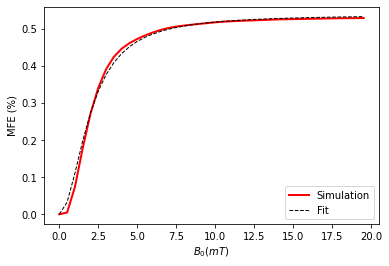

In [30]:
Bmax=20
dB=0.5
tmax=10e-6
dt=10e-9
flavin = rp.simulation.Molecule.fromdb("flavin_anion", ["H25"])  # , "H27", "H29"])
trp = rp.simulation.Molecule.fromdb("tryptophan_cation", ["H1"])  # , "Hbeta1"])
sim = LiouvilleSimulation([flavin, trp])
time = np.arange(0, tmax, dt)
Bs = np.arange(0, Bmax, dB)
krec = 1.1e7
kesc = 7e6
kSTD = 1e8
kr = 7e7

results = mary(
    sim,
    init_state=State.TRIPLET,
    obs_state=State.TRIPLET,
    time=time,
    B=Bs,
    D=0,
    J=0,
    kinetics=[
        rp.kinetics.Haberkorn(krec, State.SINGLET),
        rp.kinetics.HaberkornFree(kesc),
    ],
    relaxations=[
        relaxation.SingletTripletDephasing(kSTD),
        relaxation.RandomFields(kr),
    ],
)
MARY = results["MARY"]
HFE = results["HFE"]
LFE = results["LFE"]

# np.save("./examples/data/fad_mary/results_5nuc_liouville_relaxation.npy", results)

Bhalf, fit_result, fit_error, R2 = rp.utils.Bhalf_fit(Bs, MARY)

plt.plot(Bs, MARY, color="red", linewidth=2)
plt.plot(Bs, fit_result, "k--", linewidth=1, label="Lorentzian fit")

plt.xlabel("$B_0 (mT)$")
plt.ylabel("MFE (%)")
plt.title("")
plt.legend([r"Simulation", r"Fit"])

print(f"HFE = {HFE: .2f} %")
print(f"LFE = {LFE: .2f} %")
print(f"B1/2 = {Bhalf: .2f} mT")
print(f"B1/2 fit error = {fit_error[1]: .2f} mT")
print(f"R^2 for B1/2 fit = {R2: .3f}")

---

### Anisotropic magnetic field effects

In [40]:
theta_steps = 17
phi_steps = 32
tmax = 5e-6
dt = 5e-9

theta = np.linspace(0, np.pi, theta_steps)
phi = np.linspace(0, 2 * np.pi, phi_steps)

flavin = rp.simulation.Molecule.fromdb("flavin_anion", ["N5"])
Z = rp.simulation.Molecule("zorro", [])
sim = rp.simulation.HilbertSimulation([flavin, Z])

time = np.arange(0, tmax, dt)
B0 = 0.05
k = 1e6

results = anisotropy(
    sim,
    init_state=State.SINGLET,
    obs_state=State.SINGLET,
    time=time,
    theta=theta,
    phi=phi,
    B0=B0,
    D=0,
    J=0,
    kinetics=[rp.kinetics.Exponential(k)],
)

100%|██████████| 544/544 [00:25<00:00, 21.23it/s]


Y_av=np.complex128(0.5675464013099244+0j)
delta_phi_s=np.complex128(0.1612148258103347+0j)
gamma_s=np.complex128(0.2840557625565824+0j)


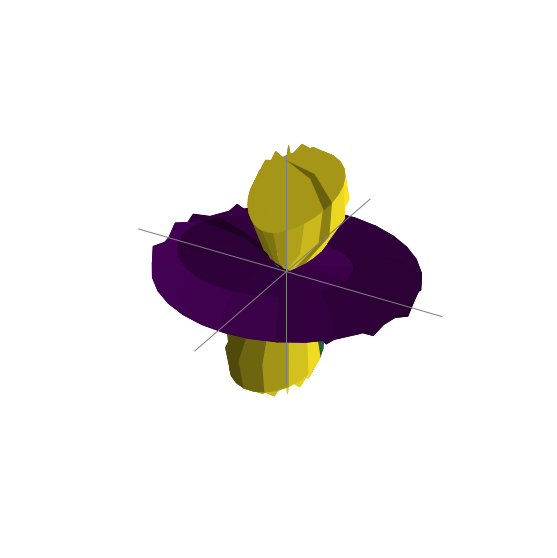

In [43]:
Y = results["product_yield_sums"]
delta_phi_s, gamma_s = rp.utils.yield_anisotropy(Y, theta, phi)
Y_av = rp.utils.spherical_average(Y, theta, phi)
Y = Y - Y_av

rp.plot.anisotropy_surface(theta, phi, Y)

print(f"{Y_av=}")
print(f"{delta_phi_s=}")
print(f"{gamma_s=}")

---

### Kine-quantum (time-resolved MARY)

In [6]:
ke = Rate(1e6, "k_{E}")  # geminate RP to free radical separation
kr = Rate(2e6, "k_{R}")  # reverse electron transfer of RP to groundstate
kfr = Rate(1e5, "k_{FR}")  # free radical recombination

FR = "FR"
SS, STp, ST0, STm = "SS", "ST_+", "ST_0", "ST_-"
TpS, TpTp, TpT0, TpTm = "T_+S", "T_+T_+", "T_+T_0", "T_+T_-"
T0S, T0Tp, T0T0, T0Tm = "T_0S", "T_0T_+", "T_0T_0", "T_0T_-"
TmS, TmTp, TmT0, TmTm = "T_-S", "T_-T_+", "T_-T_0", "T_-T_-"

base = {}
base[FR] = {FR: -kfr, SS: ke, TpTp: ke, T0T0: ke, TmTm: ke}

base[SS] = {SS: -(kr + ke)}
base[STp] = {STp: -(kr + ke)}
base[ST0] = {ST0: -(kr + ke)}
base[STm] = {STm: -(kr + ke)}

base[TpS] = {TpS: -(kr + ke)}
base[TpTp] = {TpTp: -ke}
base[TpT0] = {TpT0: -ke}
base[TpTm] = {TpTm: -ke}

base[T0S] = {T0S: -(kr + ke)}
base[T0Tp] = {T0Tp: -ke}
base[T0T0] = {T0T0: -ke}
base[T0Tm] = {T0Tm: -ke}

base[TmS] = {TmS: -(kr + ke)}
base[TmTp] = {TmTp: -ke}
base[TmT0] = {TmT0: -ke}
base[TmTm] = {TmTm: -ke}

rate_eq = RateEquations(base)
mat = rate_eq.matrix.todense()
rho0 = np.array(
    [
        0,  # FR
        0,  # SS
        0,  # ST+
        0,  # ST0
        0,  # ST-
        0,  # T+S
        1/3,  # T+T+
        0,  # T+T0
        0,  # T+T-
        0,  # T0S
        0,  # T0T+
        1/3,  # T0T0
        0,  # T0T-
        0,  # T-S
        0,  # T-T+
        0,  # T-0
        1/3,  # T-T-
    ]
)

In [23]:
flavin = Molecule.all_nuclei("flavin_anion")
trp = Molecule.all_nuclei("tryptophan_cation")
sim = SemiclassicalSimulation([flavin, trp], basis=Basis.ZEEMAN)

num_samples = 200
time = np.linspace(0, 20e-6, 100)
Bs = np.linspace(0, 30, 40)
krfr = 3e6
kstd = 1e7

results = kine_quantum_mary(
        sim,
        num_samples,
        rho0,
        radical_pair=[1, 17],
        ts=time,
        Bs=Bs,
        D=0,
        J=0,
        kinetics=mat,
        relaxations=[relaxation.RandomFields(krfr), relaxation.SingletTripletDephasing(kstd)],
    )

100%|██████████| 40/40 [00:52<00:00,  1.31s/it]


In [24]:
zero_free_radical = np.zeros((len(time), len(Bs)), dtype=complex)
free_radical = results["yield"][:, 0, :]

for i in range(0, len(Bs)):
    zero_free_radical[:, i] = free_radical[:, 0]

mary_free_radical = np.real(free_radical - zero_free_radical)

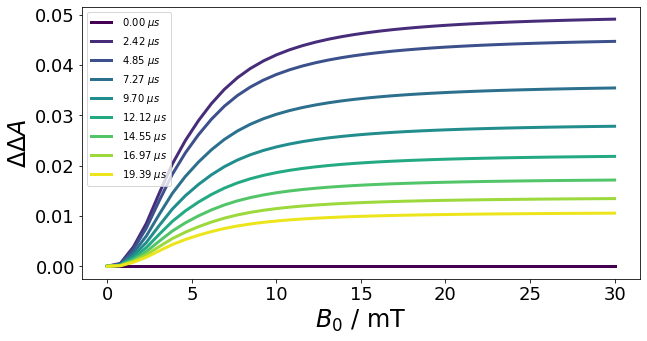

In [25]:
n = 12
f = 7
factor = 1e6
colors_time = plt.colormaps.get_cmap("viridis").resampled(len(time)).colors
colors_field = plt.colormaps.get_cmap("viridis").resampled(len(Bs)).colors

xlabel = r"$B_0$ / mT"
ylabel = r"$\Delta \Delta A$"
for i in range(0, len(time), n):
    plot_general(
        Bs,
        mary_free_radical[i, :],
        xlabel,
        ylabel,
        style="-",
        label=f"{time[i] * factor: .2f} $\\mu s$",
        colors=colors_time[i]
    )

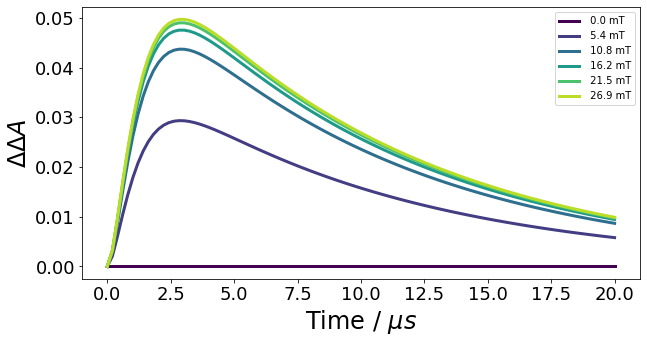

In [26]:
xlabel = r"Time / $\mu s$"
ylabel = r"$\Delta \Delta A$"
for i in range(0, len(Bs), f):
    plot_general(
        time,
        mary_free_radical[:, i],
        xlabel,
        ylabel,
        style="-",
        label=f"{Bs[i]: .1f} mT",
        colors=colors_field[i],
        factor=factor,
    )

---

### B1/2 time evolution

In [27]:
bhalf_time = np.zeros((len(mary_free_radical)))
fit_time = np.zeros((len(Bs), len(mary_free_radical)))
fit_error_time = np.zeros((2, len(mary_free_radical)))
R2_time = np.zeros((len(mary_free_radical)))

for i in range(2, len(mary_free_radical)):
    (
        bhalf_time[i],
        fit_time[:, i],
        fit_error_time[:, i],
        R2_time[i],
    ) = Bhalf_fit(Bs, mary_free_radical[i, :])

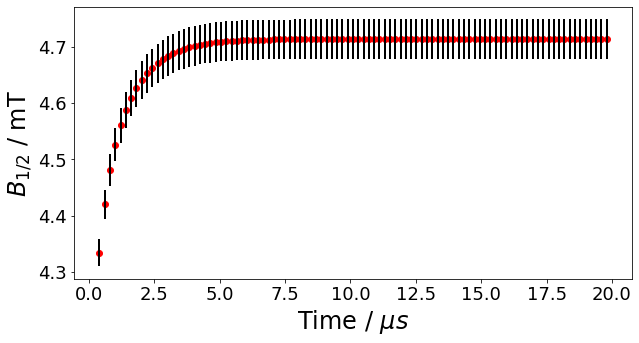

In [28]:
cutoff = -1
time = time[:cutoff]
bhalf_time = bhalf_time[:cutoff]

plt.figure()
for i in range(2, len(time)):
    plt.plot(time[i] * factor, bhalf_time[i], "ro", linewidth=3)
    plt.errorbar(
        time[i] * factor,
        bhalf_time[i],
        fit_error_time[1, i],
        color="k",
        linewidth=2,
    )
plt.xlabel(r"Time / $\mu s$", size=24)
plt.ylabel("$B_{1/2}$ / mT", size=24)
plt.tick_params(labelsize=18)
plt.gcf().set_size_inches(10, 5)

---

### Spin-correlated triplet pairs (Figure 7 from Antill and Vatai, JCTC, 20, 9488-9499, 2024)

In [35]:
Bs = np.arange(0, 2500, 10)
D = -6.2
E = 35
J = 499.55
k0 = 1
ks = 1.1e9
kd = 2.8e9

m = Triplet()
sim = LiouvilleSimulation(molecules=[m, m], basis=Basis.ZEEMAN)
rhos, Phi_s = steady_state_mary(
    sim,
    obs=State.TP_SINGLET,
    Bs=Bs,
    D=D,
    E=E,
    J=J,
    theta=np.pi / 4,
    phi=0,
    kinetics=[Haberkorn(ks, State.TP_SINGLET), HaberkornFree(kd)],
)
rhos *= k0
Phi_s *= k0 * ks

MFE = ((np.abs(Phi_s) - np.abs(Phi_s[0])) / np.abs(Phi_s[0])) * 100

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:04<00:00, 60.34it/s]


<Figure size 432x288 with 0 Axes>

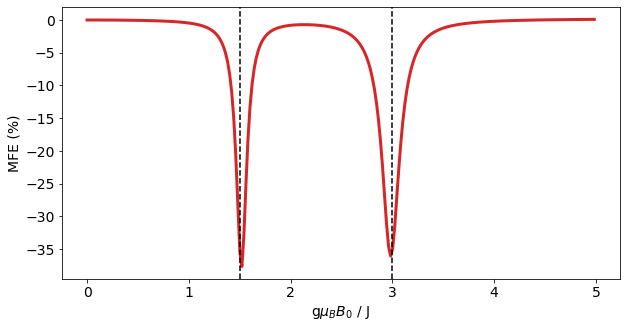

In [36]:
plt.clf()
fig = plt.figure()
plt.grid(False)
plt.axis("on")
plt.rc("axes", edgecolor="k")
plt.plot(Bs / J, MFE, linewidth=3, color="tab:red")
plt.xlabel("g$μ_B$$B_0$ / J", size=14)
plt.ylabel("MFE (%)", size=14)
plt.axvline(x=1.5, color="k", linestyle="--")
plt.axvline(x=3, color="k", linestyle="--")
plt.tick_params(labelsize=14)
fig.set_size_inches(10, 5)